In [1]:
from waylay import WaylayClient, WaylayError

# deploy  your own statistical models (BYOML)
This notebook illustrates how to use `analytics.query` and `byoml` services through the Waylay Python SDK.

We create a simple statistical model, train it, deploy it to the [Bring Your Own Model](https://docs.waylay.io/features/byoml/) server, and test it.

In [2]:
waylay_client = WaylayClient.from_profile('demo')

The following calls illustrate how to check your access to the BYOML services, list currently deployed models,
and get the metadata for an existing model.

In [3]:
waylay_client.byoml.about.health()

'OK'

In [4]:
waylay_client.byoml.model.list()

[{'createdBy': None,
  'createdOn': '2021-01-04T00:00:00+00:00',
  'description': 'Webinar TensorFlow Model',
  'framework': 'tensorflow',
  'name': 'test-model',
  'updatedBy': None,
  'updatedOn': '2021-01-04T00:00:00+00:00'},
 {'createdBy': 'users/2ad92b0a-38f4-42fc-bfa2-1b77852822fe',
  'createdOn': '2021-01-04T00:00:00+00:00',
  'description': 'isolationforest demo',
  'framework': 'sklearn',
  'name': 'isolationforest',
  'updatedBy': 'users/2ad92b0a-38f4-42fc-bfa2-1b77852822fe',
  'updatedOn': '2021-01-04T00:00:00+00:00'},
 {'createdBy': None,
  'createdOn': '2021-01-04T00:00:00+00:00',
  'description': 'This model also support probabilities',
  'framework': 'sklearn',
  'name': 'probabilities',
  'updatedBy': None,
  'updatedOn': '2021-01-04T00:00:00+00:00'},
 {'createdBy': None,
  'createdOn': '2021-01-04T00:00:00+00:00',
  'description': 'Webinar TensorFlow Model',
  'framework': 'tensorflow',
  'name': 'webinar-tf-model',
  'updatedBy': None,
  'updatedOn': '2021-01-04T00:00

In [5]:
waylay_client.byoml.model.list_names()

['test-model', 'isolationforest', 'probabilities', 'webinar-tf-model']

In [6]:
waylay_client.byoml.model.get('test-model')

{'createdBy': None,
 'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'Webinar TensorFlow Model',
 'framework': 'tensorflow',
 'name': 'test-model',
 'supported_endpoints': ['predict'],
 'updatedBy': None,
 'updatedOn': '2021-01-04T00:00:00+00:00'}

In [7]:
waylay_client.byoml.model.examples('test-model')

[{'endpoint': 'predict',
  'payload': {'instances': [{'previous_month': [0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5,
      0.5

## gathering test data
For this example we use timeseries data already stored on the platform, and query it using the `analytics.query` api/

<AxesSubplot:xlabel='timestamp'>

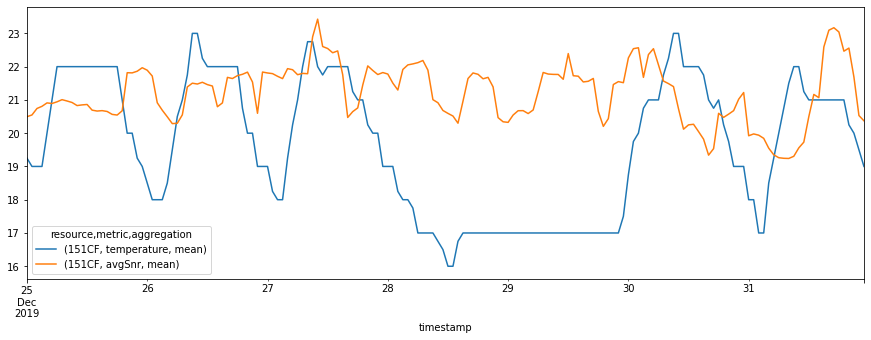

In [8]:
train_query = dict(
    resource='151CF',
    metric='temperature', 
    freq='PT1H',
    aggregation='mean',
    until='2020-01-01T00:00:00Z',
    data=[dict(metric='temperature'),dict(metric='avgSnr')]
)
train_df = waylay_client.analytics.query.execute(body=train_query)
train_df.plot(figsize=(15,5))

## creating a model
We create a simple [sklearn outlier detection](https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection) model and fit it to the above data.

In [9]:
from sklearn.covariance import EllipticEnvelope
import pandas as pd

cov_model = EllipticEnvelope(random_state=0, contamination=0.05).fit(train_df)

## validate the model locally
we use a modified query to retrieve a dataset that validates the model locally (using the sklearn `predict` call)

<AxesSubplot:xlabel='timestamp'>

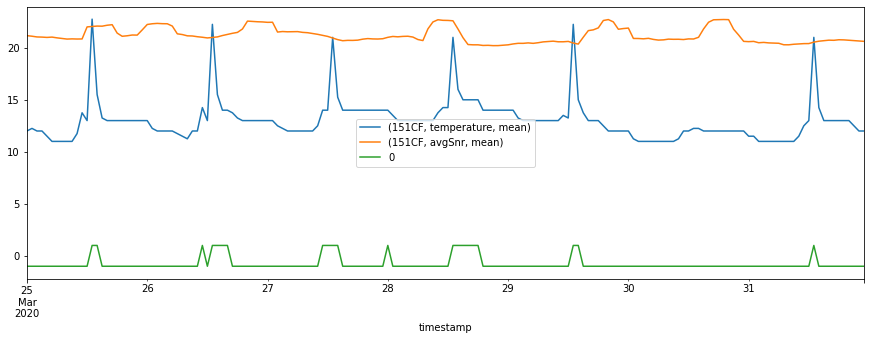

In [10]:
validation_query = dict(train_query)
validation_query['until']='2020-04-01'
df_validate = waylay_client.analytics.query.execute(body=validation_query)
df_estimate=pd.DataFrame(
    cov_model.predict(df_validate), 
    index=df_validate.index
)
pd.concat([df_validate,df_estimate], axis=1).plot(figsize=(15,5))

## upload the model to BYOML
we upload the model under a the name `live-coding` (but first delete any existing model under that name)

In [11]:
model_name="live-coding"

In [12]:
try:
    waylay_client.byoml.model.remove(model_name)
except WaylayError as exc:
    print(exc)
waylay_client.byoml.model.upload(model_name, cov_model, framework="sklearn", description="live coding !!!")

ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml.waylay.io/models/live-coding')


{'message': 'Model successfully uploaded'}

In [13]:
waylay_client.byoml.model.get(model_name)

{'createdBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'createdOn': '2021-03-08T11:33:50.435055+00:00',
 'description': 'live coding !!!',
 'framework': 'sklearn',
 'name': 'live-coding',
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'updatedOn': '2021-03-08T11:33:50.435106+00:00'}

## use the BYOML model
It takes a few seconds until the model is ready. The service will return a _409_ error if byoml is still preparing the deployment.

You might need to retry the next cell a few times until it is ready.

In [20]:
try:
    result = waylay_client.byoml.model.predict(model_name, df_validate.values.tolist())
except WaylayError as exc:
    result = str(exc)
result

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

By default the data is returned as a _numpy_ array.

You can use the `raw` or `response_constructor` parameters if this doesn't suite your needs.
See [Custom Response Handling](Custom%20Response%20Handling.ipynb) for more details.

,is_anomaly
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
163,-1
164,-1
165,-1
166,-1


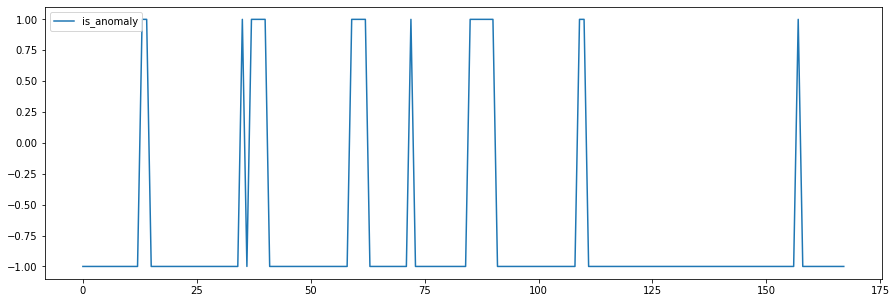

In [21]:
def to_anomaly_df(data):
    return pd.DataFrame(data, columns=['is_anomaly'])

try:
    predictions = waylay_client.byoml.model.predict(
        model_name, df_validate.values.tolist(),
        response_constructor=to_anomaly_df
    )
    predictions.plot(figsize=(15,5))
except WaylayError as exc:
    predictions = str(exc)
predictions

Byoml models can be deleted as follows.
(in this case we check that previous cells executed correctly before deleting)

In [22]:
result='ignoring delete'
if isinstance(predictions, pd.DataFrame):
    try:
        result = waylay_client.byoml.model.remove(model_name)
    except WaylayError as exc:
        result = str(exc)
result

{'message': 'Model successfully deleted'}